In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# pd.set_option('display.max_rows', None)

# Getting the Counts of Vitals to be Potentially Used for Illness Scores

```
with vital_ids as
(
select *
from d_items di
where lower(di.category) like '%vital%'
or lower(di.label) like any (array[
	'%heart%', '%respiratory rate%', '%resp rate%', '%o2 sat%', '%spo2%',
	'%temperature%', '%nbp%', '%arterial blood pressure%', '%mean arterial%']
)
), chart_vitals as 
(
  select *
  from chartevents ce
  join vital_ids v
  	on ce.itemid = v.itemid
)
select cv.label, cv.category, cv.unitname, cv.param_type, count(*)
from chart_vitals cv
group by cv.label, cv.category, cv.unitname, cv.param_type;

```

In [4]:
vital_counts = pd.read_csv('data_table_csvs/vital_counts.csv')

In [5]:
vital_counts.sort_values(by='label')

,label,category,unitname,param_type,count
23,2nd O2 Sat,NaN,NaN,NaN,74
86,ART BP Diastolic,Routine Vital Signs,mmHg,Numeric,86507
92,ART BP Systolic,Routine Vital Signs,mmHg,Numeric,86557
83,ART BP mean,Routine Vital Signs,mmHg,Numeric,87182
72,Access Site Observed (Tandem Heart),Tandem Heart,NaN,Checkbox,653
...,...,...,...,...,...
89,Type (Tandem Heart),Tandem Heart,NaN,Text,704
12,VEN0US O2 SAT,NaN,NaN,NaN,2
97,VENOUS O2 SAT,NaN,NaN,NaN,1
103,venous o2 sat,NaN,NaN,NaN,1


# Creating a Table with Mean Heart Rate Taken for Subjects over 24 Hours in the ICU
```
with heart_ids as (
  select di.itemid, di.label
  from d_items di
  where lower(di.label) = 'heart rate' or lower(di.label) = 'heart rhythm'
), hr_first24 as 
(
  select
    ce.subject_id,
    ce.hadm_id,
    ce.icustay_id,
    ce.charttime,
	hi.label,
    ce.valuenum as hr
  from chartevents ce
  join heart_ids hi
  	on ce.itemid = hi.itemid
  join icustays icu 
    on ce.icustay_id = icu.icustay_id
  where ce.valuenum is not null
    and ce.charttime between icu.intime and icu.intime + interval '24 hours'
), hr_agg as 
(
  select
    hr.subject_id,
    hr.hadm_id,
    hr.icustay_id,
	hr.label,
    avg(hr) as hr_mean_24h
  from hr_first24 hr
  group by hr.subject_id, hr.hadm_id, hr.icustay_id, hr.label
), output_table as (
select
  hr.subject_id,
  hr.hadm_id,
  hr.icustay_id,
  hr.label,
  case
    when extract(year from age(a.admittime, p.dob)) >= 300 then 90
    else extract(year from age(a.admittime, p.dob))
  end::int as age_years,
  hr.hr_mean_24h
from hr_agg as hr
join admissions as a
  on a.hadm_id = hr.hadm_id
join patients  as p
  on p.subject_id = hr.subject_id
where 
  (case
  	when extract(year from age(a.admittime, p.dob)) >= 300 THEN 90
    else extract(year from age(a.admittime, p.dob))
   end) > 0
order by age_years
)
select * from output_table;
```

In [6]:
age_with_heart = pd.read_csv('data_table_csvs/age_with_hr_data.csv')
age_with_heart = age_with_heart[age_with_heart['age_years'] >= 16]


In [7]:
age_with_heart

,subject_id,hadm_id,icustay_id,label,age_years,hr_mean_24h
9,6213,162758,254086,Heart Rate,16,125.295455
10,79506,166783,235724,Heart Rate,16,50.250000
11,6959,164365,287321,Heart Rate,16,106.560000
12,2429,107896,275975,Heart Rate,16,98.478261
13,31036,180690,271191,Heart Rate,16,113.400000
...,...,...,...,...,...,...
52306,91143,114555,251204,Heart Rate,90,60.333333
52307,91142,140022,232953,Heart Rate,90,76.285714
52308,89556,125422,239926,Heart Rate,90,80.388889
52309,91102,167828,280740,Heart Rate,90,92.235294


In [8]:
age_with_heart['age_years'].value_counts().sort_index()
age_order = ['16-24', '25-44', '45-64', '65-84', '>85']

# 16-24, 25-44, 45-64, 65-84, >85
def age_brackets(age):
    if age >= 16 and age <= 24:
        return '16-24'
    elif age >= 25 and age <=44:
        return '25-44'
    elif age >= 45 and age <= 64:
        return '45-64'
    elif age >= 65 and age <= 84:
        return '65-84'
    else:
        return '>85'
age_with_heart['age_brackets'] = age_with_heart['age_years'].apply(age_brackets)
age_with_heart['age_brackets'] = pd.Categorical(
    age_with_heart['age_brackets'],
    categories=age_order,
    ordered=True
)

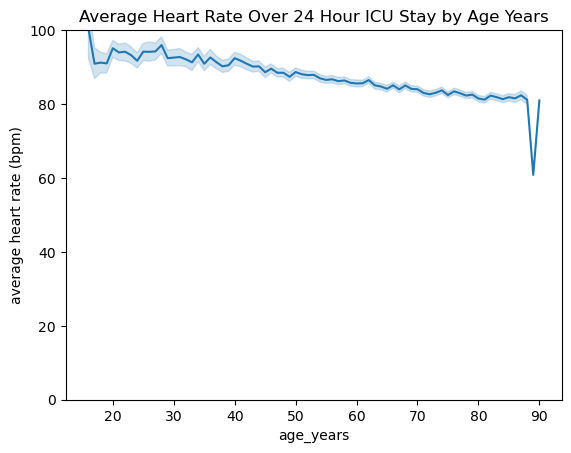

In [9]:
sns.lineplot(
    data=age_with_heart,
    x='age_years',
    y='hr_mean_24h'
)
plt.title('Average Heart Rate Over 24 Hour ICU Stay by Age Years')
plt.ylabel('average heart rate (bpm)')
plt.ylim(0, 100)
plt.show()


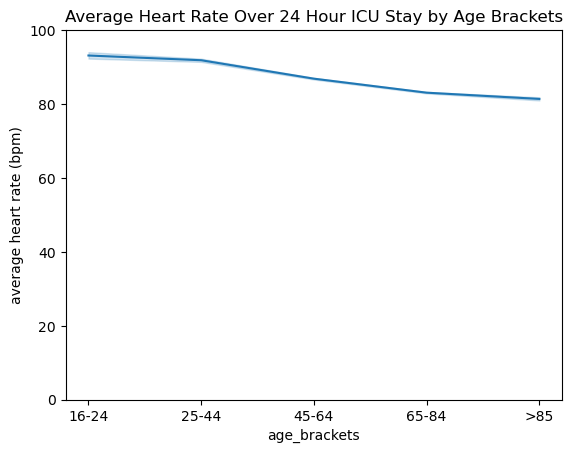

In [10]:
sns.lineplot(data=age_with_heart, x='age_brackets', y='hr_mean_24h')
plt.title('Average Heart Rate Over 24 Hour ICU Stay by Age Brackets')
plt.ylabel('average heart rate (bpm)')
plt.ylim(0, 100)
plt.show()


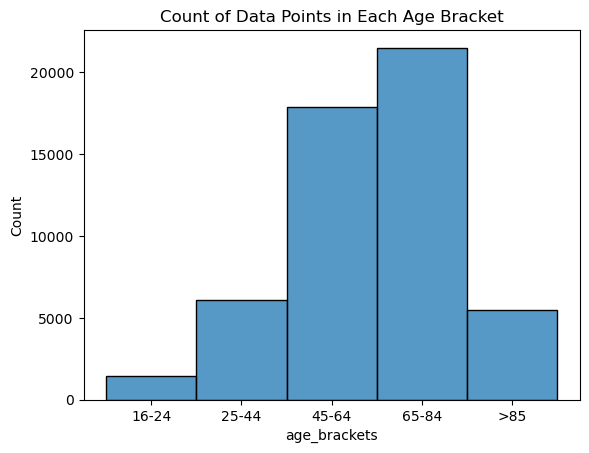

In [11]:
sns.histplot(age_with_heart['age_brackets'])
plt.title('Count of Data Points in Each Age Bracket')
plt.show()


In [13]:
cohort = pd.read_csv('data_table_csvs/final_cohort.csv')
cohort['age_brackets'] = cohort['age_years'].apply(age_brackets)
cohort['age_brackets'] = pd.Categorical(
    cohort['age_brackets'],
    categories=age_order,
    ordered=True
)


In [14]:
cohort

,subject_id,hadm_id,icustay_id,gender,age_years,admission_type,admission_type_grp,intime,outtime,icu_los_days,hosp_los_days,hosp_mortality,n_distinct_icd9,icd9_codes,icd9_code_titles,icd9_json,age_brackets
0,58526,100001,275225,F,35,EMERGENCY,non-elective,2117-09-11 11:47:35,2117-09-15 17:57:14,4.2567,6.207639,0,16,"{25013,25043,25053,25063,25083,3371,36201,4039...","{""25013 — Diabetes with ketoacidosis, type I [...","[{""code"": ""25013"", ""title"": ""Diabetes with ket...",25-44
1,54610,100003,209281,M,60,EMERGENCY,non-elective,2150-04-17 15:35:42,2150-04-19 14:12:52,1.9425,4.080556,0,9,"{07054,2851,4019,45621,53100,53550,53789,5715,...","{""07054 — Chronic hepatitis C without mention ...","[{""code"": ""07054"", ""title"": ""Chronic hepatitis...",45-64
2,9895,100006,291788,F,49,EMERGENCY,non-elective,2108-04-06 15:50:15,2108-04-11 15:18:03,4.9776,12.061806,0,9,"{20300,2761,3090,486,49320,51881,7850,V1251,V1...","{""20300 — Multiple myeloma, without mention of...","[{""code"": ""20300"", ""title"": ""Multiple myeloma,...",45-64
3,23018,100007,217937,F,74,EMERGENCY,non-elective,2145-03-31 10:17:23,2145-04-04 12:41:10,4.0998,7.296528,0,5,"{4019,486,5570,56081,9973}","{""4019 — Unspecified essential hypertension"",""...","[{""code"": ""4019"", ""title"": ""Unspecified essent...",65-84
4,533,100009,253656,M,61,EMERGENCY,non-elective,2162-05-17 10:18:31,2162-05-19 22:05:14,2.4908,4.903472,0,18,"{25000,2720,27800,2859,4019,4111,41401,4142,41...","{""25000 — Diabetes mellitus without mention of...","[{""code"": ""25000"", ""title"": ""Diabetes mellitus...",45-64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36603,94911,199992,294585,F,86,EMERGENCY,non-elective,2155-02-11 17:13:23,2155-02-12 15:29:40,0.9280,2.891667,0,15,"{0539,1120,2449,2760,2859,32723,42789,44382,50...","{""0539 — Herpes zoster without mention of comp...","[{""code"": ""0539"", ""title"": ""Herpes zoster with...",>85
36604,20785,199993,271752,M,60,EMERGENCY,non-elective,2161-10-23 18:01:44,2161-11-17 08:10:41,24.5895,24.589583,0,9,"{2760,41031,4240,4271,42731,42821,5119,5180,5184}","{""2760 — Hyperosmolality and/or hypernatremia""...","[{""code"": ""2760"", ""title"": ""Hyperosmolality an...",45-64
36605,19412,199995,255092,M,23,EMERGENCY,non-elective,2137-12-20 13:50:48,2137-12-23 10:19:27,2.8532,16.788194,0,10,"{04111,30401,30503,3051,4210,42971,4412,44284,...","{""04111 — Methicillin susceptible Staphylococc...","[{""code"": ""04111"", ""title"": ""Methicillin susce...",16-24
36606,27200,199998,293589,M,70,EMERGENCY,non-elective,2119-02-20 10:04:39,2119-02-21 11:34:20,1.0623,5.915972,0,16,"{2720,2724,4019,4111,41401,42731,4293,4400,443...","{""2720 — Pure hypercholesterolemia"",""2724 — Ot...","[{""code"": ""2720"", ""title"": ""Pure hypercholeste...",65-84


In [15]:
cohort.groupby('age_brackets').count()/38538

/var/folders/qp/dsjzkwhd6gz1p6cvsjsh0ktm0000gn/T/ipykernel_95135/2308260944.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cohort.groupby('age_brackets').count()/38538


,subject_id,hadm_id,icustay_id,gender,age_years,admission_type,admission_type_grp,intime,outtime,icu_los_days,hosp_los_days,hosp_mortality,n_distinct_icd9,icd9_codes,icd9_code_titles,icd9_json
age_brackets,,,,,,,,,,,,,,,,
16-24,0.030308,0.030308,0.030308,0.030308,0.030308,0.030308,0.030308,0.030308,0.030308,0.030308,0.030308,0.030308,0.030308,0.030308,0.030308,0.030308
25-44,0.117131,0.117131,0.117131,0.117131,0.117131,0.117131,0.117131,0.117131,0.117105,0.117105,0.117131,0.117131,0.117131,0.117131,0.117131,0.117131
45-64,0.331517,0.331517,0.331517,0.331517,0.331517,0.331517,0.331517,0.331517,0.331517,0.331517,0.331517,0.331517,0.331517,0.331517,0.331517,0.331517
65-84,0.408272,0.408272,0.408272,0.408272,0.408272,0.408272,0.408272,0.408272,0.408246,0.408246,0.408272,0.408272,0.408272,0.408272,0.408272,0.408272
>85,0.062691,0.062691,0.062691,0.062691,0.062691,0.062691,0.062691,0.062691,0.062691,0.062691,0.062691,0.062691,0.062691,0.062691,0.062691,0.062691


In [16]:
cohort['hosp_mortality'].mean()

0.10817307692307693

In [17]:
cohort['gender'].value_counts() / cohort['gender'].value_counts().sum()


gender
M    0.577797
F    0.422203
Name: count, dtype: float64

In [18]:
cohort['icd9_code_titles'].iloc[0]

'{"25013 — Diabetes with ketoacidosis, type I [juvenile type], uncontrolled","25043 — Diabetes with renal manifestations, type I [juvenile type], uncontrolled","25053 — Diabetes with ophthalmic manifestations, type I [juvenile type], uncontrolled","25063 — Diabetes with neurological manifestations, type I [juvenile type], uncontrolled","25083 — Diabetes with other specified manifestations, type I [juvenile type], uncontrolled","3371 — Peripheral autonomic neuropathy in disorders classified elsewhere","36201 — Background diabetic retinopathy","40390 — Hypertensive chronic kidney disease, unspecified, with chronic kidney disease stage I through stage IV, or unspecified","4580 — Orthostatic hypotension","5363 — Gastroparesis","5780 — Hematemesis","5849 — Acute kidney failure, unspecified","5853 — Chronic kidney disease, Stage III (moderate)","7078 — Chronic ulcer of other specified sites","V1351 — Personal history of pathologic fracture","V5867 — Long-term (current) use of insulin"}'

In [19]:
cohort[cohort['gender'] == 'M']['icu_los_days'].mean()


4.063471460992908